## Library

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

## Function Defining

In [2]:
# Define query, key and value matrices
def generate_data(seq_len, embed_dim):
    np.random.seed(42)
    return np.random.rand(seq_len, embed_dim)

sequence_length = 4
embedding_dim = 3
query = generate_data(sequence_length, embedding_dim)
key = generate_data(sequence_length, embedding_dim)
value =generate_data(sequence_length, embedding_dim)

# Compute attention scores
scores = np.dot(query,key.T) / np.sqrt(embedding_dim)

In [3]:
# Apply softmax to normalize scores
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / exp_x.sum(axis=-1, keepdims=True)

attention_weights = softmax(scores)

# Compute the context vector
context = np.dot(attention_weights, value)

print("Attention Weights: \n",attention_weights)
print("Contenxt Vector:\n", context)

Attention Weights: 
 [[0.32375051 0.17222556 0.2730973  0.23092663]
 [0.25716454 0.24560358 0.22609043 0.27114145]
 [0.31740217 0.17597915 0.28768293 0.21893575]
 [0.25660171 0.20177529 0.20931951 0.33230349]]
Contenxt Vector:
 [[0.40373714 0.57596851 0.65199056]
 [0.44847108 0.48422419 0.62544482]
 [0.39596332 0.58290558 0.64506672]
 [0.46435514 0.46358349 0.66743626]]


## Attention Defining

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads."

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size = x.size(0)
        # Linear projections
        q = self.query(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.key(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.value(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        # Compute attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(self.head_dim)
        attention_weights = F.softmax(scores, dim=-1)

        # Compute context
        context = torch.matmul(attention_weights, v).transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)
        return self.out(context), attention_weights

Attention Weights:
 tensor([[[[0.2646, 0.2616, 0.2385, 0.2352],
          [0.2593, 0.2629, 0.2343, 0.2434],
          [0.2643, 0.2624, 0.2297, 0.2436],
          [0.2614, 0.2622, 0.2329, 0.2434]],

         [[0.2383, 0.2708, 0.2708, 0.2202],
          [0.2375, 0.2744, 0.2704, 0.2177],
          [0.2346, 0.2758, 0.2778, 0.2119],
          [0.2396, 0.2659, 0.2703, 0.2241]]]], grad_fn=<SoftmaxBackward0>)
Context Vector:
 tensor([[[-0.4313, -0.6841,  0.0181, -0.3465,  0.3534,  0.1876,  0.2122,
          -0.7043],
         [-0.4305, -0.6825,  0.0186, -0.3454,  0.3533,  0.1873,  0.2121,
          -0.7038],
         [-0.4306, -0.6822,  0.0177, -0.3453,  0.3533,  0.1887,  0.2132,
          -0.7038],
         [-0.4310, -0.6829,  0.0181, -0.3452,  0.3520,  0.1866,  0.2110,
          -0.7040]]], grad_fn=<ViewBackward0>)


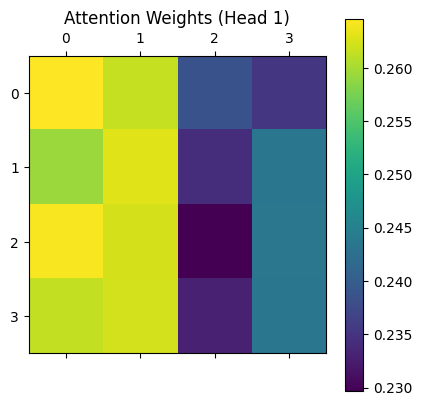

In [5]:
# Sample input
seq_len, embed_dim = 4, 8
x = torch.rand(1, seq_len, embed_dim)

# Instantiate and test
mha = MultiHeadAttention(embed_dim, num_heads=2)
context, attn_weights = mha(x)
print("Attention Weights:\n", attn_weights)
print("Context Vector:\n", context)

import matplotlib.pyplot as plt

# Visualize attention weights for a single head
plt.matshow(attn_weights[0, 0].detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title("Attention Weights (Head 1)")
plt.show()